# Import libraries and read csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import model_selection

In [3]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

# Loading datasets

In [4]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

y = train.Survived.values
test_ID = test['PassengerId']
all_data = pd.concat((train, test), sort = True).reset_index(drop=True)
all_data.drop(['Survived'], axis=1, inplace=True)
all_data.shape

(1309, 11)

# Analyse the data

In [5]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


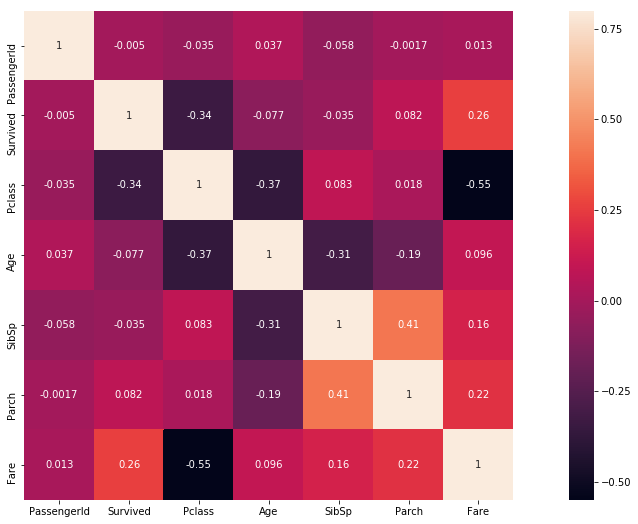

In [6]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat, vmax=0.8, square=True, annot=True)

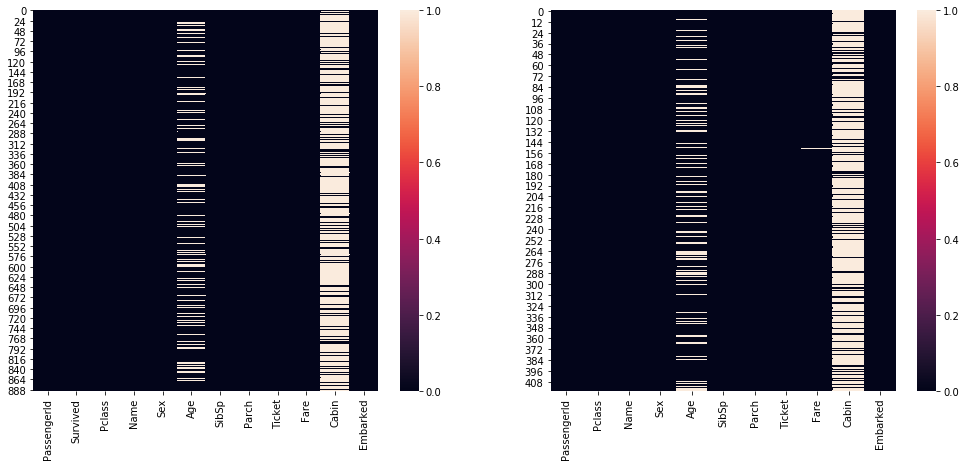

In [7]:
plt.figure(figsize=(17,7))
plt.subplot(1,2,1)
sns.heatmap(train.isnull())
plt.subplot(1,2,2)
sns.heatmap(test.isnull())

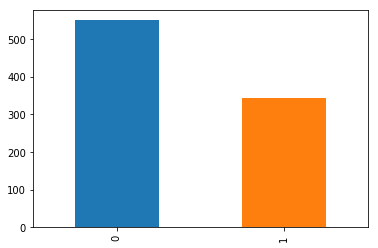

In [8]:
train['Survived'].value_counts().plot.bar()

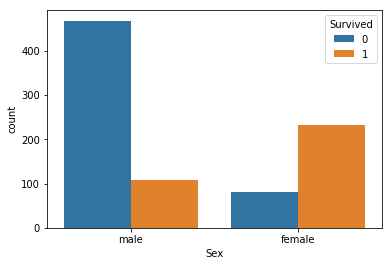

In [9]:
sns.countplot('Sex', hue='Survived', data=train)

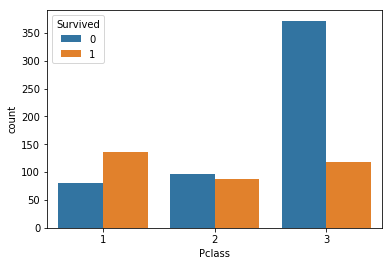

In [10]:
sns.countplot('Pclass', hue='Survived', data=train)

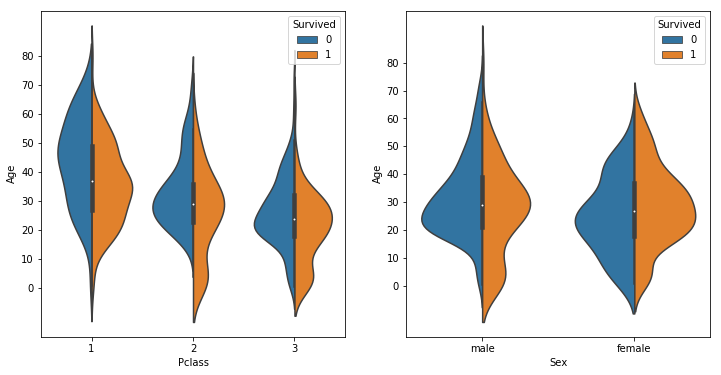

In [11]:
f, ax = plt.subplots(1,2,figsize=(12,6))
sns.violinplot('Pclass', 'Age', hue='Survived', data=train, split=True, ax=ax[0])
ax[0].set_yticks(range(0,90,10))

sns.violinplot('Sex', 'Age', hue='Survived', data=train, split=True, ax=ax[1])
ax[1].set_yticks(range(0, 90, 10))

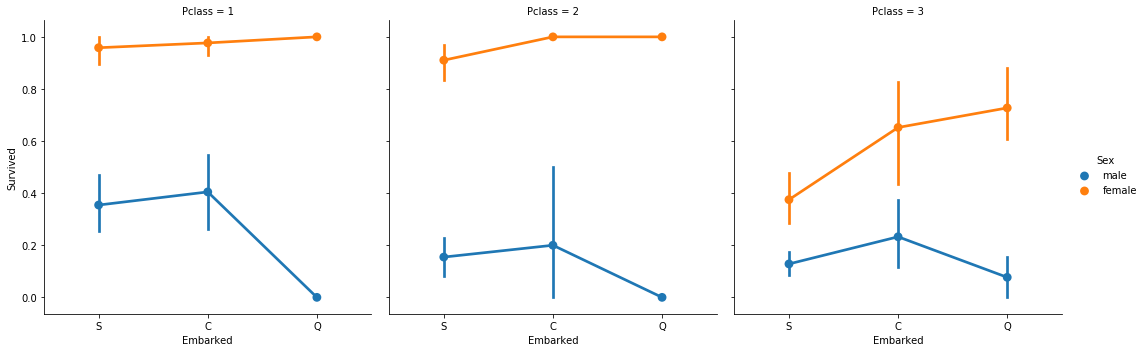

In [12]:
sns.catplot('Embarked', 'Survived', hue='Sex', col='Pclass', data=train, kind = 'point')

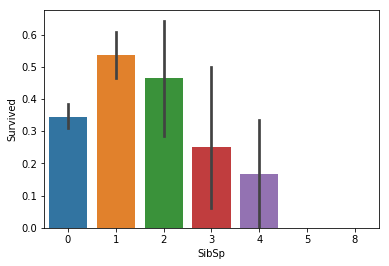

In [13]:
sns.barplot('SibSp', 'Survived', data=train)

#  Engineering features

* ### Imputing Age

I make a Title feature for imputing ages more precisely.

In [14]:
all_data['Title'] = all_data['Name']
# Cleaning name and extracting Title
for name_string in all_data['Name']:
    all_data['Title'] = all_data['Name'].str.extract('([A-Za-z]+)\.', expand=True)

mapping = {'Mlle': 'Miss',
           'Major': 'Mr',
           'Col': 'Mr',
           'Sir': 'Mr',
           'Don': 'Mr',
           'Mme': 'Miss',
           'Jonkheer': 'Mr',
           'Lady': 'Mrs',
           'Capt': 'Mr',
           'Countess': 'Mrs',
           'Ms': 'Miss',
           'Dona': 'Mrs'}

all_data.replace({'Title': mapping}, inplace=True)
all_data['Title'].shape

titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']
for title in titles:
    age_to_impute = all_data.groupby('Title')['Age'].median()[titles.index(title)]
    all_data.loc[(all_data['Age'].isnull()) & (all_data['Title'] == title), 'Age'] = age_to_impute

* ### Adding Family_Size
That's just Parch + SibSp.

In [15]:
all_data['Family_Size'] = all_data['Parch'] + all_data['SibSp']

In [16]:
all_data['AgeBin'] = pd.qcut(all_data['Age'], 4)

label = LabelEncoder()
all_data['AgeBin_Code'] = label.fit_transform(all_data['AgeBin'])

* ### Fare size to log(feature + 1) scale beacause it is too large

In [17]:
all_data['Fare'] = all_data['Fare'].fillna(all_data['Fare'].mean())
all_data['Fare'] = np.log1p(all_data['Fare'])

* ### Mapping Embarked and Sex

In [18]:
all_data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
all_data['Embarked'] = all_data['Embarked'].fillna(all_data['Fare'].median())

all_data['Sex'].replace(['male','female'],[0,1],inplace=True)

* ### Cleaning data (dropping garbage)

In [19]:
all_data.drop(['Name', 'Age', 'AgeBin', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Title'], axis = 1, inplace = True)

* ### Separate the data back:

In [20]:
train = all_data[:train.shape[0]]
test = all_data[train.shape[0]:]

In [21]:
print(train.shape)
print(test.shape)
print(y.shape)

(891, 6)
(418, 6)
(891,)


* ### So now our datasets look like this:

In [22]:
train.head()

,Embarked,Fare,Pclass,Sex,Family_Size,AgeBin_Code
0,0.0,2.110213,3,0,1,0
1,1.0,4.280593,1,1,1,3
2,0.0,2.188856,3,1,0,1
3,0.0,3.990834,1,1,1,2
4,0.0,2.202765,3,0,0,2


# Machine Learning Modeling

### Machine Learning Classification Algorithms:

* Ensemble Methods
* Generalized Linear Models (GLM)
* Naive Bayes
* Nearest Neighbors
* Support Vector Machines (SVM)
* Decision Trees
* Discriminant Analysis

In [23]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(n_estimators = 10),
    ensemble.BaggingClassifier(n_estimators = 10),
    ensemble.ExtraTreesClassifier(n_estimators = 10),
    ensemble.GradientBoostingClassifier(n_estimators = 10),
    ensemble.RandomForestClassifier(n_estimators = 10),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),  
    ]

### Generate splits

In [24]:
cv_split = model_selection.ShuffleSplit(n_splits = 10,
                                        test_size = .3,
                                        train_size = .6,
                                        random_state = 0 )

### Create table to compare MLA metrics

In [25]:
#table creating
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Time']
MLA_table = pd.DataFrame(columns = MLA_columns)

#index through MLA and save performance to table
row_index = 0

for alg in MLA:
    
    #set name and parameters
    MLA_table.loc[row_index, 'MLA Name'] = alg.__class__.__name__
    MLA_table.loc[row_index, 'MLA Parameters'] = str(alg.get_params())  
    
    #score model with cross validation
    cv_results = model_selection.cross_validate(alg, train, y, cv  = cv_split)

    MLA_table.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_table.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_table.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()

    alg.fit(train, y)

    row_index+=1
    
#print and sort table
MLA_table.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_table

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Time
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.820974,0.80597,0.00787787
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.811236,0.801866,0.0118755
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.852434,0.800746,0.190986
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.938015,0.799627,0.012361
8,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.79794,0.796642,0.00339081
14,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.797378,0.796269,0.0276446
17,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.796629,0.795149,0.00288973
18,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.798876,0.794403,0.00209386
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': 'warn',...",0.801685,0.794403,0.148056
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.940075,0.79291,0.0129058


Text(0, 0.5, 'Algorithm')

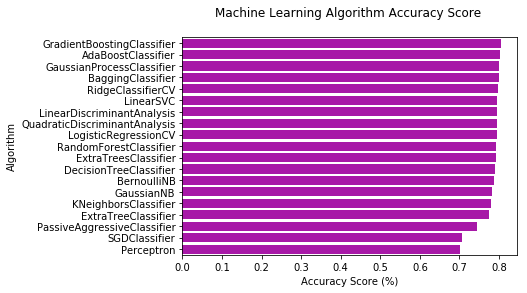

In [26]:
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_table, color = 'm')
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

### Here we see that the best results has GradientBoostingClassifier. Let's tune it and use to predict the answers:

In [27]:
gradient_boost = ensemble.GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,300,600],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150,200],
              'max_features': [0.3, 0.1] 
              }

gb_grid = model_selection.GridSearchCV(gradient_boost,
                                       param_grid = gb_param_grid,
                                       cv=cv_split, scoring="accuracy",
                                       n_jobs= 4,
                                       verbose = 1)

gb_grid.fit(train, y)

gb_best = gb_grid.best_estimator_
gb_grid.best_score_

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 336 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 836 tasks      | elapsed:   26.8s
[Parallel(n_jobs=4)]: Done 1080 out of 1080 | elapsed:   33.9s finished


0.817910447761194

In [28]:
gb_best

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=100, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [29]:
pred = gb_best.predict(test)

In [30]:
my_submission = pd.DataFrame({'PassengerId': test_ID, 'Survived': pred})
my_submission.to_csv('submission.csv', index=False)

# This model helped me reach top 12% at the competition with the score 0.80382.